### 転移学習とは
転移学習とは学習済みのモデルの最後だけを付け替え学習。もっというと最後の線形層のみ学習をさせる。→それ以外の層のパラメータは固定するといった感じになる。<br>
短いエポック数/少ないデータでも学習制度が高い。<br>
もし最後のほうのみパラメータを更新したい場合はoptimizerのところでoptim.Adam(model.parameters() , lr = 0.001)ではなくoptim.Adam(model.fc.parameters() , lr = 0.001)のように最後のパラメータのみ指定する！！

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader 
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets , models , transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
#蜂とありのデータセットを取ってくる
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2020-10-16 07:46:45--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.96, 99.86.38.106, 99.86.38.37, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  37.9MB/s    in 1.2s    

2020-10-16 07:46:46 (37.9 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
!ls

hymenoptera_data.zip  sample_data


In [5]:
#unzipを行いzipファイルを開放する。
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [6]:
!ls


hymenoptera_data  hymenoptera_data.zip	sample_data


In [7]:
!ls hymenoptera_data/

train  val


In [8]:
!ls hymenoptera_data/train/


ants  bees


In [9]:
#前処理を行っていく
transform = transforms.Compose([
                                transforms.Resize((224 , 224)),#ここでリサイズを行っていく。
                                transforms.ToTensor(),
                                transforms.Normalize((0.5 , ) , (0.5 ,))
])

In [10]:
#フォルダの中にある画像をとってくる。
train_dataset = datasets.ImageFolder("./hymenoptera_data/train/", transform=transform)#学習で使用したいフォルダを指定する。今回の指定だとtrainの下にあるantsとbeesのフォルダが使用される。


In [11]:
#trainデータのロード
train_loader = DataLoader(train_dataset , batch_size=32 , shuffle=True)

In [12]:
#データを取り出して確認してみる。
data_iter = iter(train_loader)
imgs , labels = data_iter.next()
labels

tensor([0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0])

In [13]:
imgs.size()#バッチ数,チャンネルサイズ,画像のサイズ、画像のサイズ

torch.Size([32, 3, 224, 224])

In [14]:
img = imgs[0]
img_permute = img.permute(1,2,0)#チャネルラスト
img_permute = 0.5 * img_permute + 0.5 #正規化したのを元に戻している。
img_permute = np.clip(img_permute , 0 , 1)#0 ~ 1の範囲にしている。 

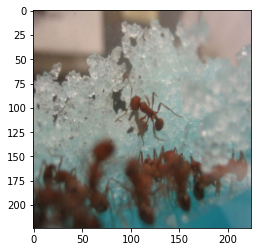

In [15]:
plt.imshow(img_permute)

In [16]:
labels[0]
#ありが0、蜂が1になっている。

tensor(0)

In [17]:
#モデルの作成を行っていく。
model = models.resnet18(pretrained=True)#pretrainedで学習済みのモデルを使用する事が出来る。

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [19]:
#モデルを確認する。
#今回は最後のfcのところだけ変更を行う。
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
#これを行うと勾配計算が行われなくなる。
for params in model.parameters():
    params.requires_grad = False


In [22]:
#最後のfcのところだけ更新を行う。
model.fc = nn.Linear(512 , 2)#in_featuresが512,out_featuresが2になっている。

In [23]:
model
#最後のfcの部分を確認するとout_featuresが1000から2に変更されていることが分かる。

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
#modelをGPUにおく
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
#損失関数を定義
criterion = nn.CrossEntropyLoss()
#勾配
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)

In [28]:
num_epochs = 15
losses = []
accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs , labels in train_loader:#バッチごとに回していく
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output , labels)
        running_loss += loss.item()
        pred = torch.argmax(output , dim = 1)
        running_acc += torch.mean(pred.eq(labels).float())
        loss.backward()
        optimizer.step()

    running_loss /= len(train_loader)
    running_acc /= len(train_loader)
    losses.append(running_loss)
    accs.append(running_acc)
    print("epoch: {} , loss: {} , acc: {}".format(epoch , running_loss , running_acc))


epoch: 0 , loss: 0.4228500835597515 , acc: 0.856249988079071
epoch: 1 , loss: 0.30788860097527504 , acc: 0.9375
epoch: 2 , loss: 0.248690040782094 , acc: 0.953125
epoch: 3 , loss: 0.2087297048419714 , acc: 0.95703125
epoch: 4 , loss: 0.1923337522894144 , acc: 0.95703125
epoch: 5 , loss: 0.18091411236673594 , acc: 0.9468749761581421
epoch: 6 , loss: 0.19178569689393044 , acc: 0.921875
epoch: 7 , loss: 0.16484048124402761 , acc: 0.9703124761581421
epoch: 8 , loss: 0.1354532027617097 , acc: 0.9703124761581421
epoch: 9 , loss: 0.15643740724772215 , acc: 0.95703125
epoch: 10 , loss: 0.13518411945551634 , acc: 0.97265625
epoch: 11 , loss: 0.1435118978843093 , acc: 0.9664062261581421
epoch: 12 , loss: 0.15261672157794237 , acc: 0.952343761920929
epoch: 13 , loss: 0.13859663717448711 , acc: 0.969531238079071
epoch: 14 , loss: 0.10711255203932524 , acc: 0.967968761920929


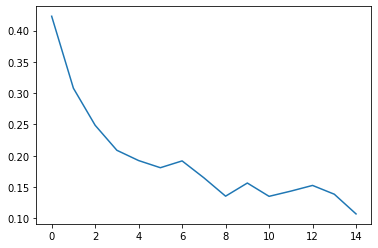

In [29]:
plt.plot(losses)

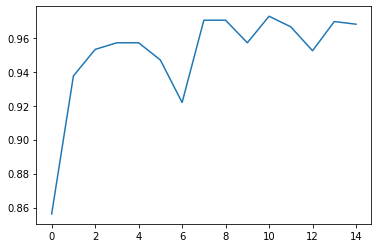

In [30]:
plt.plot(accs)